# Missing Data Handling, Visualization & Lasso

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

all_data = pd.concat([test_df, train_df])

## NaN Handling

Let's find out first which columns have the most NaN values.

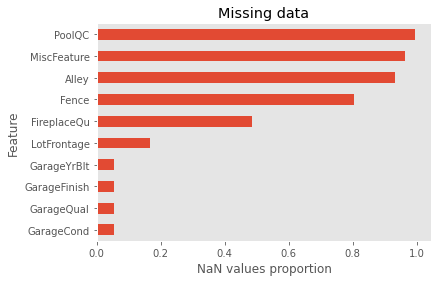

In [20]:
def plot_nans(data):
    ax = (data.isna().sum() / data.shape[0]).loc[data.isna().sum() / data.shape[0] > 0].sort_values().drop("SalePrice")[-10:].plot.barh(title='Missing data')
    ax.set_ylabel("Feature")
    ax.set_xlabel("NaN values proportion")
    plt.grid(False)
    plt.show()

plot_nans(all_data)

In [21]:
# --- MEANS ----
all_data['LotFrontage'] = all_data['LotFrontage'].fillna(all_data['LotFrontage'].median())

# --- ZEROs ----
# No garage -> 0
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].fillna(0)
all_data['BsmtFinSF2'] = all_data['BsmtFinSF2'].fillna(0)
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].fillna(0)
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(0)
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(0)

all_data['GarageCars'] = all_data['GarageCars'].fillna(0)
all_data['GarageArea'] = all_data['GarageArea'].fillna(0)

In [22]:
# Change some int variables to categorical as they are that
all_data['MoSold'] = all_data['MoSold'].astype('category')

# One-hot encoding
all_data = pd.get_dummies(all_data)

# Split back to train and test dataframes
print("Data shape", all_data.shape)
train_df = all_data.loc[all_data['SalePrice'].isnull() == False]
test_df = all_data.loc[all_data['SalePrice'].isnull() == True].drop('SalePrice', axis=1)
print(test_df.isna().sum().loc[test_df.isna().sum() > 0])

Data shape (2919, 301)
Series([], dtype: int64)


## Descriptive Analysis

In [23]:
train_df.drop('Id', axis=1).describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    69.686301   10516.828082     6.099315     5.575342   
std      42.300571    22.037950    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    60.000000    7553.500000     5.000000     5.000000   
50%      50.000000    68.000000    9478.500000     6.000000     5.000000   
75%      70.000000    79.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.117123   443.639726    46.549315  ...   
std      30.202904     20.645407   180.731373   456.098091   161.319273  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000  ...   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000  ...   
75%    2000.000000   2004.000000   164.250000   712.250000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000  ...   

       SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
count     1460.000000   1460.000000   1460.000000  1460.000000   
mean         0.003425      0.083562      0.002055     0.867808   
std          0.058440      0.276824      0.045299     0.338815   
min          0.000000      0.000000      0.000000     0.000000   
25%          0.000000      0.000000      0.000000     1.000000   
50%          0.000000      0.000000      0.000000     1.000000   
75%          0.000000      0.000000      0.000000     1.000000   
max          1.000000      1.000000      1.000000     1.000000   

       SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
count            1460.000000            1460.000000           1460.000000   
mean                0.069178               0.002740              0.008219   
std                 0.253844               0.052289              0.090317   
min                 0.000000               0.000000              0.000000   
25%                 0.000000               0.000000              0.000000   
50%                 0.000000               0.000000              0.000000   
75%                 0.000000               0.000000              0.000000   
max                 1.000000               1.000000              1.000000   

       SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
count           1460.000000           1460.000000            1460.000000  
mean               0.013699              0.820548               0.085616  
std                0.116277              0.383862               0.279893  
min                0.000000              0.000000               0.000000  
25%                0.000000              1.000000               0.000000  
50%                0.000000              1.000000               0.000000  
75%                0.000000              1.000000               0.000000  
max                1.000000              1.000000               1.000000  

[8 rows x 300 columns]

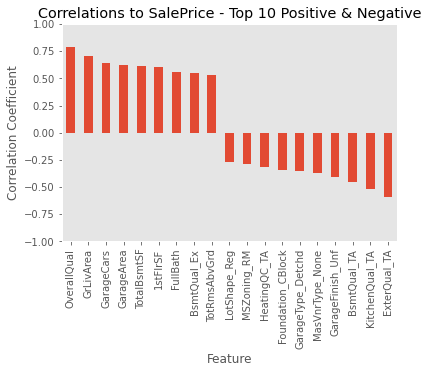

In [24]:
# Highest Pearson correlations
top20 = pd.concat([train_df.corr()['SalePrice'].sort_values(ascending=False)[1:10], train_df.corr()['SalePrice'].sort_values(ascending=False)[-10:]])
ax = top20.plot.bar()
ax.set_ylim(-1.0, 1.0)
plt.title("Correlations to SalePrice - Top 10 Positive & Negative")
plt.xlabel("Feature")
plt.ylabel("Correlation Coefficient")
plt.grid(False)
plt.show()

## Exploratory Analysis

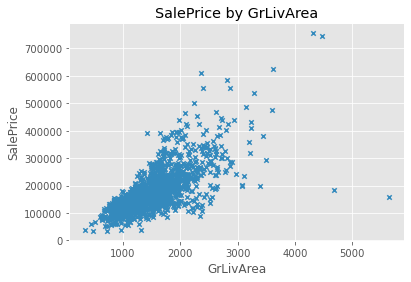

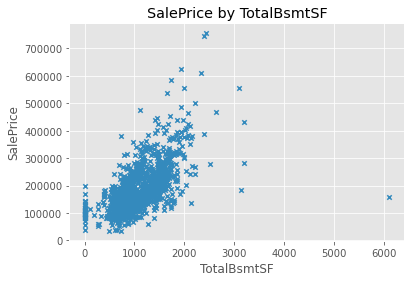

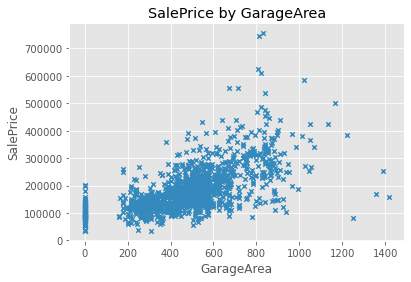

In [25]:
train_df.plot.scatter(x='GrLivArea', y='SalePrice', title="SalePrice by GrLivArea", marker='x')
train_df.plot.scatter(x='TotalBsmtSF', y='SalePrice', title="SalePrice by TotalBsmtSF", marker='x')
train_df.plot.scatter(x='GarageArea', y='SalePrice', title="SalePrice by GarageArea", marker='x')
plt.show()

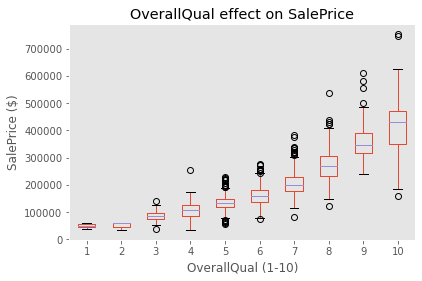

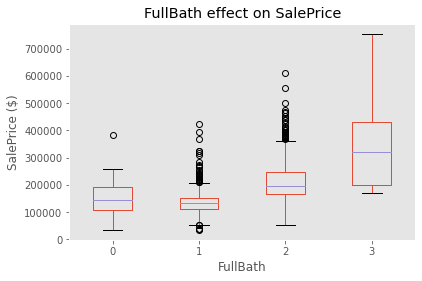

In [26]:
train_df.boxplot(column='SalePrice', by='OverallQual', grid=False)
plt.title("OverallQual effect on SalePrice")
plt.ylabel("SalePrice ($)")
plt.xlabel("OverallQual (1-10)")
plt.suptitle('')
plt.show()

train_df.boxplot(column='SalePrice', by='FullBath', grid=False)
plt.title("FullBath effect on SalePrice")
plt.ylabel("SalePrice ($)")
plt.suptitle('')
plt.show()

## Train-test split

In [27]:
# Train-test split
from sklearn.model_selection import train_test_split
X = train_df.drop(['Id', 'SalePrice'], axis=1).values

# Square root of the output to make high values less dominant
y = np.sqrt(train_df['SalePrice'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Outlier removal

In [28]:
from sklearn.ensemble import IsolationForest
from scipy import stats
def remove_outliers(X_tr, y_tr, mode):
    if mode == "isolation":
        iso = IsolationForest(contamination=0.1)
        yhat = iso.fit_predict(X_tr)
        mask = (yhat != -1)
    elif mode == 'z-score':
        z = np.nan_to_num(np.abs(stats.zscore(X_tr)))
        mask = (z < 15).all(axis=1)

    org_shape = X_tr.shape
    X_tr, y_tr = X_tr[mask, :], y_tr[mask]
    print("Removed", (~mask).sum(), "of", org_shape[0], "samples")
    
    
    return X_tr, y_tr
X_train, y_train = remove_outliers(X_train, y_train, "isolation")

Removed 98 of 978 samples


In [29]:
# ML Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

coefs = []
rmses = []
alphas = []
k_variables = 'all'
alfa = 2
while alfa >= 0:
    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('zero variance removal', VarianceThreshold()), 
                     ('feature_selection', SelectKBest(f_regression, k=k_variables)), 
                     ('regressor', Lasso(alpha=alfa, max_iter=100000))])
    
    pipe.fit(X_train, y_train)
    coefs.append(pipe['regressor'].coef_)
    rmses.append(mean_squared_error(np.log(y_test**2), np.log(pipe.predict(X_test)**2), squared=False))
    alphas.append(alfa)
    alfa -= 0.05
    
coefs = np.array(coefs)
best_alpha = alphas[np.argmin(rmses)]

In [30]:
used_features = train_df.drop(['Id', 'SalePrice'], axis=1).columns.values[pipe['zero variance removal'].get_support()][pipe['feature_selection'].get_support()]
coef_inds = (-np.abs(coefs)).mean(axis=0).argsort()
coef_inds = np.expand_dims(coef_inds, axis=0).repeat(coefs.shape[0], axis=0)
sorted_coefs = np.take_along_axis(coefs, coef_inds, axis=1)
sorted_used_features = used_features[(-np.abs(coefs)).mean(axis=0).argsort()]

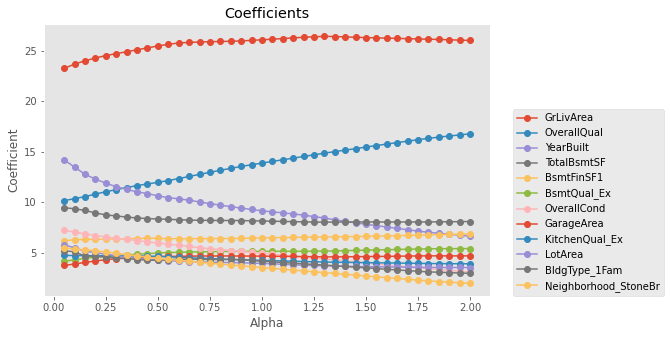

In [31]:
show_n_best = 12
plt.figure(figsize=(8,5))
plt.plot(alphas, sorted_coefs[:,:show_n_best], '-o')
plt.title('Coefficients')
plt.xlabel('Alpha')
plt.ylabel("Coefficient")
plt.legend(sorted_used_features[:show_n_best], loc=(1.05,0))
plt.grid(False)
plt.show()

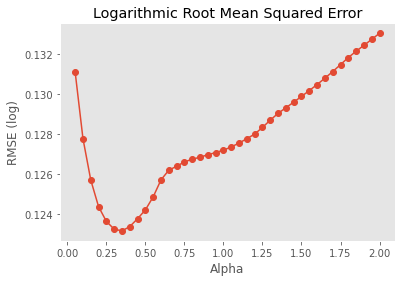

In [32]:
plt.plot(alphas, rmses, '-o')
plt.title('Logarithmic Root Mean Squared Error')
plt.xlabel('Alpha')
plt.ylabel("RMSE (log)")
plt.grid(False)
plt.show()

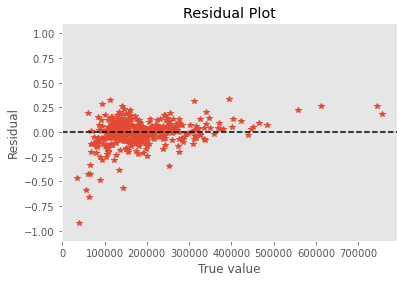

In [33]:
# Residuals for best alpha
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('zero variance removal', VarianceThreshold()), 
                 ('feature_selection', SelectKBest(f_regression, k=k_variables)), 
                 ('regressor', Lasso(alpha=best_alpha, max_iter=100000))])
pipe.fit(X_train, y_train)

residuals = np.log(y_test**2) - np.log(pipe.predict(X_test)**2)
arr1inds = y_test.argsort()
y_test_sorted = (y_test**2)[arr1inds[::-1]]
residuals_sorted = residuals[arr1inds[::-1]]
plt.plot(y_test_sorted, residuals_sorted, '*')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("True value")
plt.ylabel("Residual")
plt.ylim(-1.1,1.1)
plt.title("Residual Plot")
plt.grid(False)
plt.show()

## Final Model Fitting

In [ ]:

# Outlier removal for all train data
X, y = remove_outliers(X, y, 'isolation')

pipe = Pipeline([('scaler', StandardScaler()), 
                     ('zero variance removal', VarianceThreshold()), 
                     ('feature_selection', SelectKBest(f_regression, k=k_variables)), 
                     ('regressor', Lasso(alpha=best_alpha, max_iter=100000))])
pipe.fit(X, y)

In [ ]:
# Validation for Kaggle competition
X_valid = test_df.drop('Id', axis=1).values

y_pred_valid = pipe.predict(X_valid)**2
final_submission = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": y_pred_valid})
final_submission.to_csv("final_submission.csv", index=False)
final_submission.head()